In [34]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import imageio.v2 as imageio
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.basemap import Basemap, maskoceans

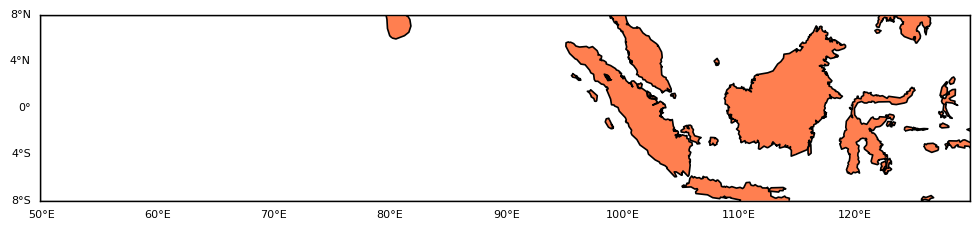

In [42]:
plt.figure(figsize=(12,8))
    
#draw basemap
# m = Basemap(projection='cyl',llcrnrlon=0,urcrnrlon=357.5,llcrnrlat=-90,urcrnrlat=90,resolution='l')
# m.fillcontinents(color='coral',lake_color='aqua')
# m.drawcoastlines(linewidth=0.7)
# m.drawmapboundary()

# #draw latitudes and longitudes
# parallels = np.arange(-90,91,20)
# m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0,fontsize=10)
# meridians = np.arange(0,361,40)
# m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0,fontsize=10)

m = Basemap(projection='cyl',llcrnrlon=50,urcrnrlon=130,llcrnrlat=-8,urcrnrlat=8,resolution='l')
m.fillcontinents(color='coral',lake_color='aqua')
m.drawcoastlines(linewidth=1.2)
m.drawmapboundary()

#draw latitudes and longitudes
parallels = np.arange(-8,9,4)
m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0,fontsize=8)
meridians = np.arange(50,130,10)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0,fontsize=8)

# plt.vlines([60,120],-8,8,colors='red',linewidths=3)
# plt.hlines([-8,8],60,120,colors='red',linewidths=3)

plt.savefig("map_small.png",dpi=300,bbox_inches='tight')

plt.show()

### Open filtered Kelvin Wave OLRs 

In [2]:
kelvin_olr = np.load("../Filtering MJO-Kelvin/Filtered OLRs/kelvin_olr.npy")
lon = np.arange(0,360,2.5)

### Open MJO RMM phase dataset and choose base phase

In [3]:
rmm = xr.open_dataset("../Filtering MJO-Kelvin/mjo_rmm_1979-2020.nc")
mjo_phase = np.array(rmm["phase"])[:-1]

## Load compiled dynamical data

In [4]:
uwind = np.load("/free2/cd859229/era5/uwind_1979-2020_era5.npy")
wwind = np.load("/free2/cd859229/era5/wwind_1979-2020_era5.npy")
hgt = np.load("/free2/cd859229/era5/hgt_1979-2020_era5.npy")
temp = np.load("/free2/cd859229/era5/temp_1979-2020_era5.npy")
q = np.load("/free2/cd859229/era5/q_1979-2020_era5.npy")

In [5]:
pressures = np.array([1000,975,950,925,900,875,850,825,800,775,750,700,650,600,550,500,\
                     450,400,350,300,250,225,200,175,150,125,100])

## Functions for getting anomalies via regression

In [6]:
#inputs data: matrix Y (observed values)
#inputs nharm: number of harmonics
def anomalies(data,nharm):
    tau = 365.25 #period is one year
    
    #create matrix of predictors X
    X = np.ones((data.shape[0],2*nharm+1))
    
    #time indices for sine and cosine functions
    t = np.arange(data.shape[0])

    #cos and sin predictors with harmonics
    for i,j in enumerate(np.arange(1,2*nharm+1,2)):
        X[:,j] = np.cos(2*np.pi*(i+1)*t/tau)
        X[:,j+1] = np.sin(2*np.pi*(i+1)*t/tau)
        
    left = (X.T).dot(np.transpose(data,axes=(1,0,2)))
        
    C = np.linalg.inv((X.T).dot(X)).dot(np.transpose(left,axes=(1,0,2))) 

    #calculate predicted Y
    Ypred = X.dot(np.transpose(C,axes=(1,0,2)))
    
    return (data-Ypred) 

## Get anomalies of dynamical data

In [7]:
#get geopotential height anomalies
hgt_anoms = anomalies(hgt,3)

#get uwind anomalies
uwind_anoms = anomalies(uwind,3)

#get wwind anomalies
wwind_anoms = anomalies(wwind,3)

#get temperature anomalies
temp_anoms = anomalies(temp,3)

# #get q anomalies
q_anoms = anomalies(q,3)

## Find days with Kelvin wave passing through base longitude for different RMM phase

In [8]:
def minima(arr):
    sign = np.sign(np.diff(arr)) #get sign of differences
    
    #local minima should have -1,1 consecutive
    test_right = np.where(sign==1)[0]-1 #find all +1 in array then get left index
    test_left = np.where(sign[test_right] == -1)[0] #check if left of +1 is -1
    
    #if yes include index
    min_in = test_right[test_left]+1
    
    return(min_in)

def find_days(base_phase,base_lon,bootstrap=False,day_size=0):#,mean_data_anom,mean_uwind_anom,mean_vwind_anom,mean_olr_anom):        
    #get index of longitude
    lon_in = np.where(lon==base_lon)[0][0]
        
    if bootstrap == True:
        #get average Kelvin OLR anomalies at -15 to 15 lat and base longitude
        kelvin_base = np.mean(kelvin_olr[:,:,lon_in],axis=0) 

        #get negative OLR anomalies 
        neg_ind = np.where(kelvin_base<0)[0]
        kelvin_base_neg = kelvin_base[neg_ind]

        min_ind = minima(kelvin_base_neg) #get indices of minima
        min_kelvin = kelvin_base_neg[min_ind] #kelvin olr with minima

        kelvin_std = np.std(kelvin_olr) #get std of kelvin time series
        std_ind = np.where(min_kelvin <= -kelvin_std)
        
        k_days = neg_ind[min_ind][std_ind] # get days with kelvin wave passing through base lon
        rand_in = np.random.randint(low=0,high=len(k_days),size=day_size)
        
        days = k_days[rand_in]
    
    else:
        #get index of phase
        phase_in = np.where(mjo_phase==base_phase)[0]

        #get average Kelvin OLR anomalies at -15 to 15 lat and base longitude
        kelvin_base = np.mean(kelvin_olr[:,phase_in,lon_in],axis=0) 

        #get negative OLR anomalies 
        neg_ind = np.where(kelvin_base<0)[0]
        kelvin_base_neg = kelvin_base[neg_ind]

        min_ind = minima(kelvin_base_neg) #get indices of minima
        min_kelvin = kelvin_base_neg[min_ind] #kelvin olr with minima

        kelvin_std = np.std(kelvin_olr) #get std of kelvin time series
        std_ind = np.where(min_kelvin <= -kelvin_std)

        #get indices of days with Kelvin wave passing through base longitude during RMM base phase
        days = phase_in[neg_ind][min_ind][std_ind]
    
    return days

In [9]:
#convert wwind from Pa/s to m/s
def convert_height(pascals):
    k = 101325
    alpha = 2.25577E-5
    beta = 5.25588
    
    H = (1-(pascals/k)**(1/beta))/alpha
    
    return H

### Convert air temperature to potential temperature

In [10]:
#convert air temperature to potential temperature
def potential_temp(temp,P):
    P0 = 1000
    K = 0.286
    
    theta = temp*((P0/P)**K)
    
    return theta

In [11]:
theta = potential_temp(temp,pressures)

#get potential temperature anomalies
theta_anoms = anomalies(theta,3)

## Get zonal and vertical wind anomalies corresponding to base phase and base longitude

In [12]:
base_lon = 80

momentum = np.zeros((360,9,8))
heat = np.zeros((360,9,8))
moisture = np.zeros((360,9,8))

one_Pa = convert_height(1)

for i in range(8):
    base_phase = i+1
    
    #get days with kelvin wave passing through base longitude during base RMM phase
    test_days = find_days(base_phase,base_lon) 
    
    #get wind anomalies
    uwind_prime = uwind_anoms[test_days,:,:]
    wwind_prime = wwind_anoms[test_days,:,:]
    
    #get temperature anomalies
    theta_prime = theta_anoms[test_days,:,:]
    
    #get specific humidity anomalies
    q_prime = q_anoms[test_days,:,:]

    #calculate momentum flux
    momentum[:,:,i] = np.mean(wwind_prime*uwind_prime,axis=0)[:,:9]
    #calculate heat flux
    heat[:,:,i] = np.mean(wwind_prime*theta_prime,axis=0)[:,:9]
    # #calculate moisture flux
    moisture[:,:,i] = np.mean(wwind_prime*q_prime,axis=0)[:,:9]

# Plot momentum flux on vertical map

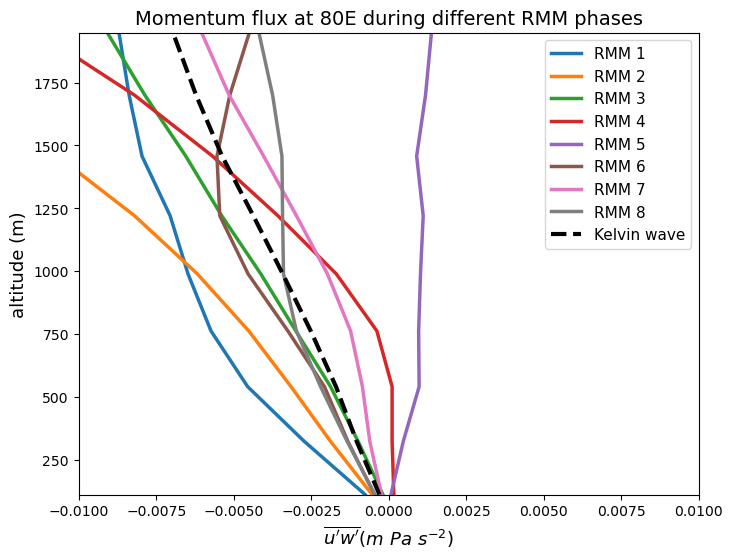

In [13]:
Y = convert_height(pressures[:9]*100)

plt.figure(figsize=(8,6))

for j in range(8):
    plt.plot(momentum[base_lon,:,j],Y,linewidth=2.5,label="RMM "+str(j+1))
    
plt.plot(np.mean(momentum[base_lon,:,:],axis=1),Y,linewidth=3,label="Kelvin wave",color="black",linestyle="--")

# plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.gca().invert_yaxis()

# plt.ylim(1000,800)
plt.xlim(-0.01,0.01)
plt.ylim(Y[0],Y[-1])

plt.title("Momentum flux at "+str(base_lon)+"E during different RMM phases",fontsize=14)
plt.xlabel("$\overline{u^\prime w^\prime} (m\ Pa\ s^{-2})$",fontsize=13)
plt.ylabel("altitude (m)", fontsize=13)
plt.legend(loc="best",fontsize=11)

# plt.savefig("momentum_"+str(base_lon)+".png",dpi=300,bbox_inches="tight")

plt.show()

# Plot heat flux on vertical map

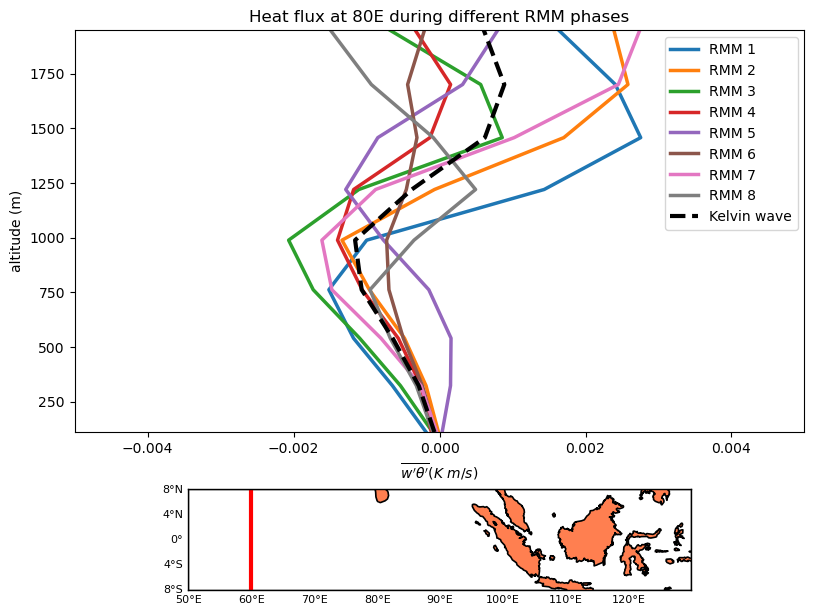

In [14]:
Y = convert_height(pressures[:9]*100)

fig, (ax1, ax2) = plt.subplots(2,figsize=(8,6),gridspec_kw={'height_ratios': [4, 1]})

for j in range(8):
    ax1.plot(heat[base_lon,:,j],Y,linewidth=2.5,label="RMM "+str(j+1))
    
ax1.plot(np.mean(heat[base_lon,:,:],axis=1),Y,linewidth=3,label="Kelvin wave",color="black",linestyle="--")

# plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.gca().invert_yaxis()

# plt.ylim(1000,800)
ax1.set_xlim(-0.005,0.005)
ax1.set_ylim(Y[0],Y[-1])

ax1.set_title("Heat flux at "+str(base_lon)+"E during different RMM phases",fontsize=12)
ax1.set(xlabel="$\overline{w^\prime θ^\prime } (K\ m/s)$", ylabel="altitude (m)")
# ax1.xlabel("$\overline{w^\prime θ^\prime } (K\ m/s)$",fontsize=13)
# ax1.ylabel("altitude (m)", fontsize=13)
ax1.legend(loc="best",fontsize=10)

#draw basemap
m = Basemap(projection='cyl',llcrnrlon=50,urcrnrlon=130,llcrnrlat=-8,urcrnrlat=8,resolution='l')
m.fillcontinents(color='coral',lake_color='aqua')
m.drawcoastlines(linewidth=1.2)
m.drawmapboundary()

#draw latitudes and longitudes
parallels = np.arange(-8,9,4)
m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0,fontsize=8)
meridians = np.arange(50,130,10)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0,fontsize=8)

ax2.vlines(60,-8,8,colors="red",linewidths=3)

fig.tight_layout(pad=0.2)

# plt.savefig("momentum_"+str(base_lon)+".png",dpi=300,bbox_inches="tight")

plt.show()

# Plot moisture flux on vertical map

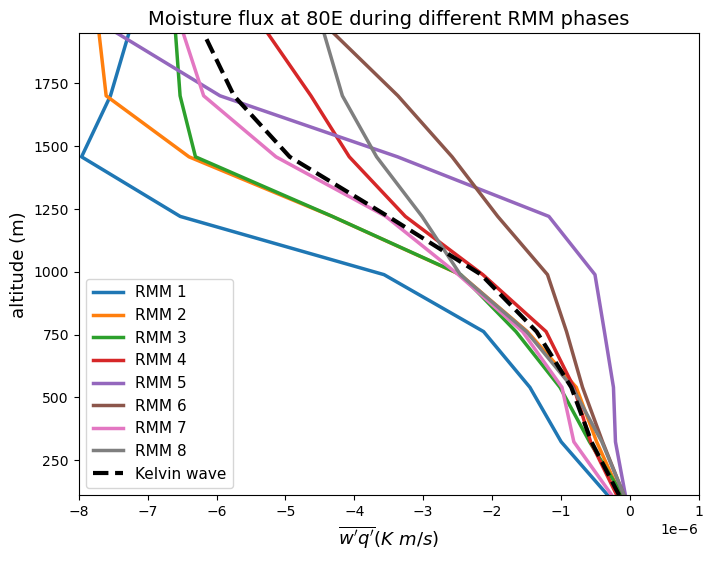

In [15]:
Y = convert_height(pressures[:9]*100)

plt.figure(figsize=(8,6))

for j in range(8):
    plt.plot(moisture[base_lon,:,j],Y,linewidth=2.5,label="RMM "+str(j+1))
    
plt.plot(np.mean(moisture[base_lon,:,:],axis=1),Y,linewidth=3,label="Kelvin wave",color="black",linestyle="--")

# plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.gca().invert_yaxis()

# plt.ylim(1000,800)
plt.xlim(-8E-6,1E-6)
plt.ylim(Y[0],Y[-1])

plt.title("Moisture flux at "+str(base_lon)+"E during different RMM phases",fontsize=14)
plt.xlabel("$\overline{w^\prime q^\prime } (K\ m/s)$",fontsize=13)
plt.ylabel("altitude (m)", fontsize=13)
plt.legend(loc="best",fontsize=11)

# plt.savefig("momentum_"+str(base_lon)+".png",dpi=300,bbox_inches="tight")

plt.show()

## Loop thru different base longitudes

In [31]:
for base_lon in range(60,125,5):
    momentum = np.zeros((360,9,8))
    heat = np.zeros((360,9,8))
    moisture = np.zeros((360,9,8))

    one_Pa = convert_height(1)

    for i in range(8):
        base_phase = i+1

        #get days with kelvin wave passing through base longitude during base RMM phase
        test_days = find_days(base_phase,base_lon) 

        #get wind anomalies
        uwind_prime = uwind_anoms[test_days,:,:]
        wwind_prime = wwind_anoms[test_days,:,:]

        #get temperature anomalies
        theta_prime = theta_anoms[test_days,:,:]

        #get specific humidity anomalies
        q_prime = q_anoms[test_days,:,:]

        #calculate momentum flux
        momentum[:,:,i] = np.mean(-wwind_prime*uwind_prime,axis=0)[:,:9]
        #calculate heat flux
        heat[:,:,i] = np.mean(-wwind_prime*theta_prime,axis=0)[:,:9]
        # #calculate moisture flux
        moisture[:,:,i] = np.mean(-wwind_prime*q_prime,axis=0)[:,:9]

        Y = convert_height(pressures[:9]*100)

    ################################# Momentum ###############################
    fig, (ax1, ax2) = plt.subplots(2,figsize=(8,6),gridspec_kw={'height_ratios': [4, 1]})

    for j in range(8):
        ax1.plot(momentum[base_lon,:,j],Y,linewidth=2.5,label="RMM "+str(j+1))

    ax1.plot(np.mean(momentum[base_lon,:,:],axis=1),Y,linewidth=3,label="Kelvin wave",color="black",linestyle="--")

    ax1.set_xlim(-0.01,0.02)
    ax1.set_ylim(Y[0],Y[-1])

    ax1.set_title("Momentum flux at "+str(base_lon)+"E during different RMM phases",fontsize=12)
    ax1.set(xlabel="$\overline{-u^\prime w^\prime } (m\ Pa\ s^{-2})$", ylabel="altitude (m)")
    ax1.legend(loc="best",fontsize=10)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=50,urcrnrlon=130,llcrnrlat=-8,urcrnrlat=8,resolution='l')
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcoastlines(linewidth=1.2)
    m.drawmapboundary()

    #draw latitudes and longitudes
    parallels = np.arange(-8,9,4)
    m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0,fontsize=8)
    meridians = np.arange(50,130,10)
    m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0,fontsize=8)

    ax2.vlines(base_lon,-8,8,colors="red",linewidths=3)

    fig.tight_layout(pad=0.2)
    plt.savefig("Momentum/momentum_"+str(base_lon)+".png",dpi=300,bbox_inches="tight")

    plt.close()
    ############################################################################
    
    ################################# Heat #####################################
    fig, (ax1, ax2) = plt.subplots(2,figsize=(8,6),gridspec_kw={'height_ratios': [4, 1]})

    for j in range(8):
        ax1.plot(heat[base_lon,:,j],Y,linewidth=2.5,label="RMM "+str(j+1))

    ax1.plot(np.mean(heat[base_lon,:,:],axis=1),Y,linewidth=3,label="Kelvin wave",color="black",linestyle="--")

    # plt.ylim(1000,800)
    ax1.set_xlim(-0.005,0.005)
    ax1.set_ylim(Y[0],Y[-1])

    ax1.set_title("Heat flux at "+str(base_lon)+"E during different RMM phases",fontsize=12)
    ax1.set(xlabel="$\overline{-w^\prime θ^\prime } (K\ Pa/s)$", ylabel="altitude (m)")
    ax1.legend(loc="best",fontsize=10)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=50,urcrnrlon=130,llcrnrlat=-8,urcrnrlat=8,resolution='l')
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcoastlines(linewidth=1.2)
    m.drawmapboundary()

    #draw latitudes and longitudes
    parallels = np.arange(-8,9,4)
    m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0,fontsize=8)
    meridians = np.arange(50,130,10)
    m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0,fontsize=8)

    ax2.vlines(base_lon,-8,8,colors="red",linewidths=3)

    fig.tight_layout(pad=0.2)
    plt.savefig("Heat/heat_"+str(base_lon)+".png",dpi=300,bbox_inches="tight")

    plt.close()
    ###############################################################################
    
    ################################# Moisture #####################################
    fig, (ax1, ax2) = plt.subplots(2,figsize=(8,6),gridspec_kw={'height_ratios': [4, 1]})

    for j in range(8):
        ax1.plot(moisture[base_lon,:,j],Y,linewidth=2.5,label="RMM "+str(j+1))

    ax1.plot(np.mean(moisture[base_lon,:,:],axis=1),Y,linewidth=3,label="Kelvin wave",color="black",linestyle="--")

    ax1.set_xlim(-1E-6,8E-6)
    ax1.set_ylim(Y[0],Y[-1])

    ax1.set_title("Moisture flux at "+str(base_lon)+"E during different RMM phases",fontsize=12)
    ax1.set(xlabel="$\overline{-w^\prime q^\prime } (kg/kg\ Pa/s)$", ylabel="altitude (m)")
    ax1.legend(loc="best",fontsize=10)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=50,urcrnrlon=130,llcrnrlat=-8,urcrnrlat=8,resolution='l')
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcoastlines(linewidth=1.2)
    m.drawmapboundary()

    #draw latitudes and longitudes
    parallels = np.arange(-8,9,4)
    m.drawparallels(parallels,labels=[True,False,True,False],linewidth=0,fontsize=8)
    meridians = np.arange(50,130,10)
    m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0,fontsize=8)

    ax2.vlines(base_lon,-8,8,colors="red",linewidths=3)

    fig.tight_layout(pad=0.2)
    plt.savefig("Moisture/moisture_"+str(base_lon)+".png",dpi=300,bbox_inches="tight")

    plt.close()
    ###############################################################################

### Animate Fluxes

In [32]:
movie = []

for base_lon in range(60,125,5):
    image_file = "Heat/heat_"+str(base_lon)+".png"
    movie.append(imageio.imread(image_file))
   
# imageio.mimsave("Moisture/moisture.gif", movie, format=".gif",duration=1.2)

imageio.mimsave("Heat/heat.mp4", movie,  format=".mp4", fps = 1)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2440, 1850) to (2448, 1856) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x56f5700] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [33]:
movie = []

for base_lon in range(60,125,5):
    image_file = "Moisture/moisture_"+str(base_lon)+".png"
    movie.append(imageio.imread(image_file))
   
# imageio.mimsave("Moisture/moisture.gif", movie, format=".gif",duration=1.2)

imageio.mimsave("Moisture/moisture.mp4", movie,  format=".mp4", fps = 1)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2440, 1850) to (2448, 1856) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x565f700] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [30]:
movie = []

for base_lon in range(60,125,5):
    image_file = "Momentum/momentum_"+str(base_lon)+".png"
    movie.append(imageio.imread(image_file))
   
# imageio.mimsave("Moisture/moisture.gif", movie, format=".gif",duration=1.2)

imageio.mimsave("Momentum/momentum.mp4", movie,  format=".mp4", fps = 1)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2440, 1850) to (2448, 1856) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x6a25700] Stream #0: not enough frames to estimate rate; consider increasing probesize
